<h1>AI Football Manager, part 3</h1>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline


<h3>Project Goals</h3>
<li>To sum up so far:</li>
<li>We scraped these two data sets for all of the players in the EPL, from seasons 15/16 up until the current season 18/19</li>
<li>The main objective was to see if it was possible to predict a player's performance in a given season given his physical attributes from the beginning of the season</li>
<li>After linking the FIFA data with EPL performance for every player, we normalized the data of all 4 years (using z-score standardizing) to have it consistent with every season, since on the one hand FIFA ratings vary a little over the years.</li>
<li> To verify that the data is useable, we used QQ-Plots (the closer the points are to a line, the better)

<h2> Data Preprocessing </h2>

In [3]:
def standardize_z_score(df):
    df_new = (df-df.mean())/df.std()
    return df_new

In [4]:
def data_preprocessing(df):
    from scipy import stats
    df = df.drop(['composure'], axis=1)
    for column in df.columns:
        df[column] = stats.boxcox(df[column])[0]
    
    df_last = standardize_z_score(df)
    return df_last



In [5]:
def qqplot(data, COL_NUM = 2, ROW_NUM = 3 ):
    import matplotlib.pyplot as plt
    from scipy import stats
    %matplotlib inline
    important_columns = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physicality']
    
    fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))
    
    for i , column in enumerate(important_columns):
        ax = axes[int(i/COL_NUM), i%COL_NUM]
        stats.probplot(data[column], dist='norm', plot = ax)
        ax.set_title(column+ ' QQ PLOT')
        plt.tight_layout()

<h2> Grid Search Function That Returns Best Parameters </h2>

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def grid_search(data_X, data_y):
    proportion = np.arange(0.01, 0.2, 0.03) 
    parameters = {
         'n_estimators': list(range(10,100,10)),
         'max_depth': list(range(2,10,2)),
         'min_samples_split': (2,5,10,15,20),
         'min_samples_leaf' : (2,5,10,15,20)}
                       
    model = GridSearchCV(RandomForestRegressor(),parameters,cv=3,iid=False)
    model.fit(data_X, data_y)
    parameters = model.best_params_
    return parameters

<h2> Best Features and Model Score on Average </h2>

In [7]:
def create_best_random_forest(parameters, x_train, y_train, x_test, y_test, number_models = 100):
    feature_names_infn = [key for key in x_train]
    average_importance = np.zeros(len(feature_names_infn))
    average_score = 0
    for i in range(number_models):
        b_model = RandomForestRegressor(max_depth=parameters['max_depth'],
                                    min_samples_leaf=parameters['min_samples_leaf'],
                                    min_samples_split=parameters['min_samples_split'],
                                    n_estimators=parameters['n_estimators'])
        b_model.fit(x_train,np.ravel(y_train))
        average_score += b_model.score(x_test,y_test)/number_models
        importances = b_model.feature_importances_
        
        merged = list(zip(importances,feature_names_infn))

       
        for index, (importance, name) in enumerate(merged):
            average_importance[index] += importance/number_models
        
    merged = list(zip(average_importance, feature_names_infn))
    merged.sort(key= lambda x: x[0])
    merged = merged[::-1]
    return merged, average_score

<h2> Predicting the Dependent Variable For This Season on Average </h2>

In [8]:
def predicting(parameters, x_train, y_train, x_predict, number_models=100):
    average_predicted = np.zeros(len(x_predict))
    names = x_predict['name']
    teams = x_predict['team']
    ratings = x_predict['rating']
    x_predict = x_predict.iloc[:,5:39]
    x_predict = data_preprocessing(x_predict)
    for i in range(number_models):
        b_model = RandomForestRegressor(max_depth=parameters['max_depth'],
                                    min_samples_leaf=parameters['min_samples_leaf'],
                                    min_samples_split=parameters['min_samples_split'],
                                    n_estimators=parameters['n_estimators'])
        b_model.fit(x_train,np.ravel(y_train))
        predictions = b_model.predict(x_predict)
        
        for index, value in enumerate(predictions):
            average_predicted[index] += value/number_models
    
    average = list(zip(names, teams, ratings,average_predicted))
    average.sort(key=lambda x: x[3], reverse=True)
    return average

<h2> Neural Network </h2>

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
def grid_search_neural(data_X, data_y):
    parameters = {
        'learning_rate':["constant", "invscaling", "adaptive"],
        'solver': ('sgd','lbfgs','adam'),
        'activation': ('logistic','tanh','relu'),
        'hidden_layer_sizes': ((40,),(50,),(60,)),
        'max_iter': (500, 750, 1000)
        }
    model = GridSearchCV(estimator = MLPRegressor(), param_grid=parameters,cv=3)
    model.fit(data_X, np.ravel(data_y))
    parameters = model.best_params_
    return parameters

In [10]:
def average_network(parameters, x_train, y_train, x_test, y_test, number_models = 100):
    average_score = 0
    for i in range(number_models):
        b_model = MLPRegressor(learning_rate=parameters['learning_rate'],
                                    solver=parameters['solver'],
                                    activation=parameters['activation'],
                                    hidden_layer_sizes =parameters['hidden_layer_sizes'],
                                    max_iter = parameters['max_iter'])
        b_model.fit(x_train,np.ravel(y_train))
        average_score += b_model.score(x_test,y_test)/number_models
        
    return average_score

In [11]:
def predicting_network(parameters, x_train, y_train, x_predict, number_models=100):
    average_predicted = np.zeros(len(x_predict))
    names = x_predict['name']
    teams = x_predict['team']
    ratings = x_predict['rating']
    x_predict = x_predict.iloc[:,5:39]
    x_predict = data_preprocessing(x_predict)
    for i in range(number_models):
        b_model = MLPRegressor(learning_rate=parameters['learning_rate'],
                                    solver=parameters['solver'],
                                    activation=parameters['activation'],
                                    hidden_layer_sizes =parameters['hidden_layer_sizes'],
                                    max_iter = parameters['max_iter'])
        b_model.fit(x_train,np.ravel(y_train))
        predictions = b_model.predict(x_predict)
        
        for index, value in enumerate(predictions):
            average_predicted[index] += value/number_models
    
    average = list(zip(names, teams, ratings,average_predicted))
    average.sort(key=lambda x: x[3], reverse=True)
    return average

<h1>GOALKEEPER CASE</h1>

In [12]:
goalkeeper_2019 = pd.read_csv('goalkeeper_2019.csv')
goalkeeper_2018 = pd.read_csv('goalkeeper_2018.csv')
goalkeeper_2017 = pd.read_csv('goalkeeper_2017.csv')
goalkeeper_2016 = pd.read_csv('goalkeeper_2016.csv')

In [13]:
goalkeeper_data = goalkeeper_2018.append(goalkeeper_2017,sort=False)
goalkeeper_data = goalkeeper_data.append(goalkeeper_2016, sort=False)
goalkeeper_predict = goalkeeper_2019

In [14]:
goalkeeper_data_X = goalkeeper_data.iloc[:,5:39]
goalkeeper_data_y = goalkeeper_data['saves']

goalkeeper_predict_X = goalkeeper_predict.iloc[:,5:39]
goalkeeper_predict_y = goalkeeper_predict['saves']

In [15]:
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(goalkeeper_data, test_size = 0.3)

In [16]:
train = goalkeeper_2017.append(goalkeeper_2016)
x_train = train.iloc[:, 5:39]
y_train = train['saves']

test = goalkeeper_2018
x_test = test.iloc[:, 5:39]
y_test = test['saves']

In [17]:
goalkeeper_data_X_norm = data_preprocessing(goalkeeper_data_X)
goalkeeper_predict_X_norm = data_preprocessing(goalkeeper_predict_X)
x_train_norm = data_preprocessing(x_train)
x_test_norm = data_preprocessing(x_test)

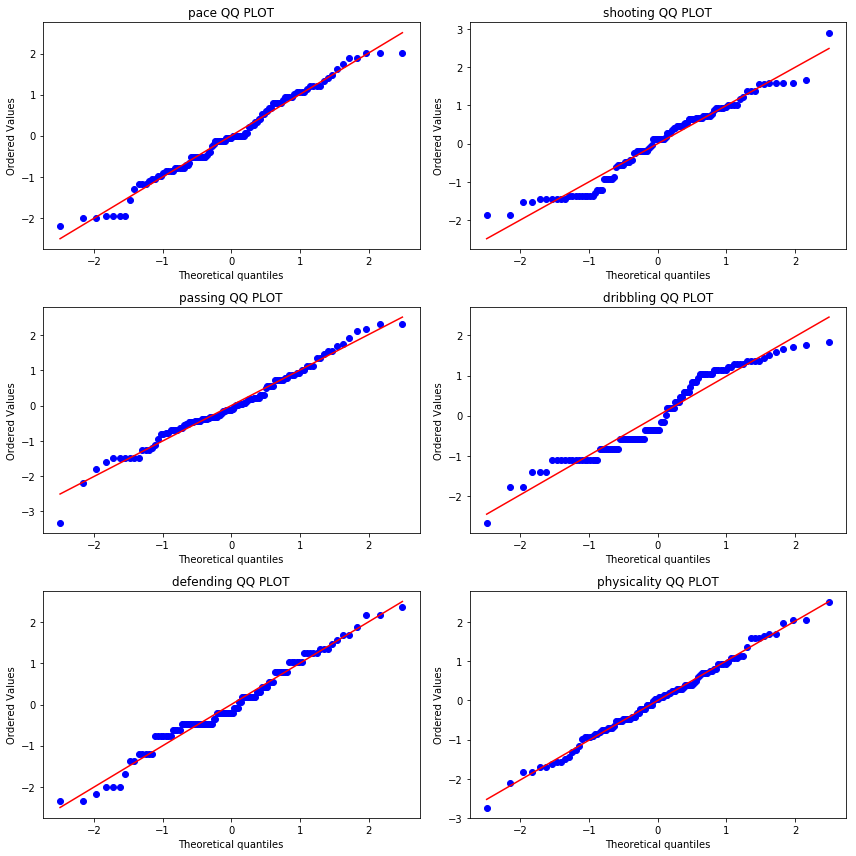

In [18]:
qqplot(goalkeeper_data_X_norm)

<h1> Linear Regression </h1>

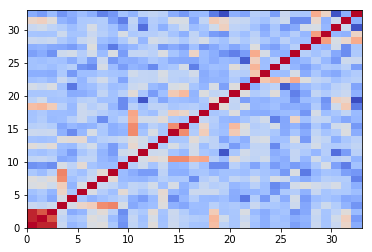

In [19]:
plt.pcolor(goalkeeper_data_X_norm.corr(),cmap='coolwarm')
plt.show()

In [20]:
model = linear_model.LinearRegression()
model.fit(x_train_norm, y_train)
goalkeeper_regression_score = model.score(x_test_norm, y_test)
goalkeeper_regression_score

-3.7378806043885664

<h1> Random Forest </h1>

In [21]:
goalkeeper_parameters = grid_search(goalkeeper_data_X_norm, goalkeeper_data_y)
goalkeeper_parameters

{'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 40}

In [22]:
goalkeeper_importances, goalkeeper_forest_score = create_best_random_forest(goalkeeper_parameters, x_train_norm, y_train, x_test_norm, y_test, number_models = 100)
goalkeeper_importances_groups = list(zip(*goalkeeper_importances))
print(goalkeeper_forest_score)

0.11737442964488486


Text(0.5,0,'Relative Importance')

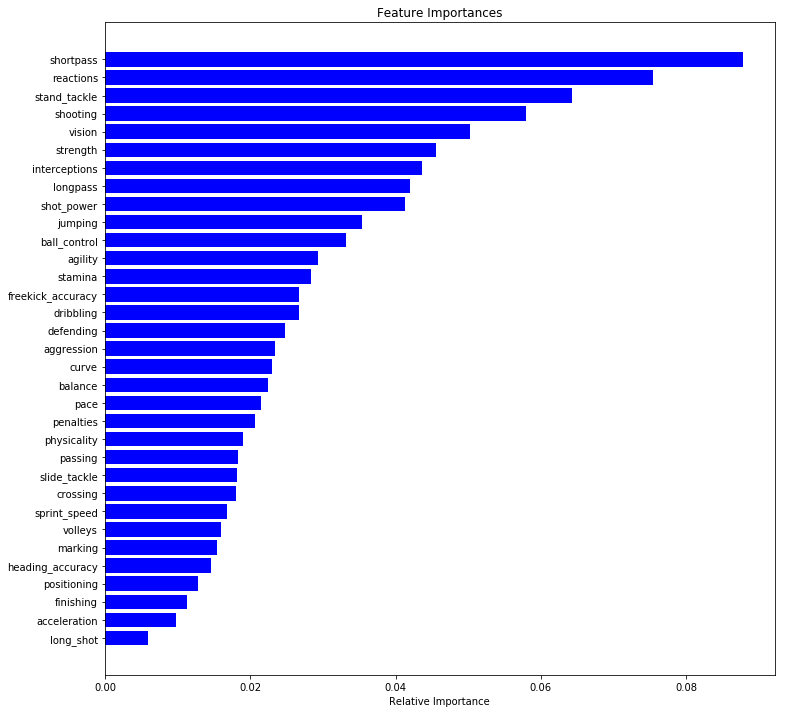

In [23]:
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(goalkeeper_importances_groups[0])), goalkeeper_importances_groups[0][::-1], color='b', align='center')
goalkeeper_feature_names = goalkeeper_importances_groups[1][::-1]

plt.yticks(range(len(goalkeeper_importances_groups[0])),goalkeeper_feature_names)
plt.xlabel('Relative Importance')

In [24]:
goalkeeper_forest_predictions = predicting(goalkeeper_parameters, goalkeeper_data_X_norm, goalkeeper_data_y, goalkeeper_2019, number_models=100)
goalkeeper_forest_predictions


[('De Gea', 'Manchester United', 91, 88.6450100420988),
 ('Mathew Ryan', 'Brighton and Hove Albion', 79, 72.64459518693656),
 ('Ederson', 'Manchester City', 86, 67.07784752130159),
 ('Lukasz Fabianski', 'West Ham United', 81, 66.87548000592385),
 ('Alisson', 'Liverpool', 85, 66.3347038815506),
 ('Kasper Schmeichel', 'Leicester City', 84, 65.49542209842575),
 ('Petr Cech', 'Arsenal', 82, 62.25515682718184),
 ('Jordan Pickford', 'Everton', 83, 57.835986615143945),
 ('Joe Hart', 'Burnley', 79, 55.755740501439696),
 ('Asmir Begovic', 'Bournemouth', 79, 55.09475045906744),
 ('Jonas Lossl', 'Huddersfield Town', 76, 54.50627594290239),
 ('Ben Foster', 'Watford', 77, 54.08187989165774),
 ('Wayne Hennessey', 'Crystal Palace', 75, 53.569693493312094),
 ('Hugo Lloris', 'Tottenham Hotspur', 88, 45.665770792754344),
 ('Bernd Leno', 'Arsenal', 84, 44.726483294688876),
 ('Alex McCarthy', 'Southampton', 77, 44.50709125605216),
 ('Paulo Gazzaniga', 'Tottenham Hotspur', 72, 43.06545890403559),
 ('Ben Ha

<h1> Neural Network </h2>

In [25]:
goalkeeper_neural_parameters = grid_search_neural(goalkeeper_data_X_norm, goalkeeper_data_y)
goalkeeper_neural_parameters

{'activation': 'relu',
 'hidden_layer_sizes': (50,),
 'learning_rate': 'invscaling',
 'max_iter': 1000,
 'solver': 'sgd'}

In [26]:
goalkeeper_neural_score=average_network(goalkeeper_neural_parameters, x_train_norm, y_train, x_test_norm, y_test, number_models = 100)
goalkeeper_neural_score

0.18298686720486498

In [27]:
goalkeeper_neural_predictions=predicting_network(goalkeeper_neural_parameters, goalkeeper_data_X_norm, goalkeeper_data_y, goalkeeper_2019, number_models=10)
goalkeeper_neural_predictions

[('Lukasz Fabianski', 'West Ham United', 81, 77.58963597958156),
 ('Ederson', 'Manchester City', 86, 70.21995528654914),
 ('De Gea', 'Manchester United', 91, 70.09827336289152),
 ('Petr Cech', 'Arsenal', 82, 68.22404693381517),
 ('Alisson', 'Liverpool', 85, 67.35535617098198),
 ('Jordan Pickford', 'Everton', 83, 62.641072804992824),
 ('Asmir Begovic', 'Bournemouth', 79, 60.11553302986953),
 ('Joe Hart', 'Burnley', 79, 56.9035770348318),
 ('Jonas Lossl', 'Huddersfield Town', 76, 56.700839200745556),
 ('Kasper Schmeichel', 'Leicester City', 84, 53.44977975586324),
 ('Paulo Gazzaniga', 'Tottenham Hotspur', 72, 51.59391980267992),
 ('Hugo Lloris', 'Tottenham Hotspur', 88, 49.62004045923691),
 ('Wayne Hennessey', 'Crystal Palace', 75, 49.4637551866573),
 ('Mathew Ryan', 'Brighton and Hove Albion', 79, 47.850935192900884),
 ('Ben Foster', 'Watford', 77, 43.973689167705864),
 ('Alex McCarthy', 'Southampton', 77, 42.98535391650121),
 ('Ben Hamer', 'Huddersfield Town', 67, 40.49049252548966),
 

<h1>DEFENDER CASE</h1>

In [130]:
defender_2019 = pd.read_csv('defender_2019.csv')
defender_2018 = pd.read_csv('defender_2018.csv')
defender_2017 = pd.read_csv('defender_2017.csv')
defender_2016 = pd.read_csv('defender_2016.csv')

In [131]:
defender_data = defender_2018.append(defender_2017,sort=False)
defender_data = defender_data.append(defender_2016, sort=False)
defender_predict = defender_2019


In [132]:
defender_data_X = defender_data.iloc[:,5:39]
defender_data_y = defender_data['tackles']

defender_predict_X = defender_predict.iloc[:,5:39]
defender_predict_y = defender_predict['tackles']

In [133]:
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(defender_data, test_size = 0.3)
train = defender_2017.append(defender_2016)

x_train = train.iloc[:, 5:39]
y_train = train['tackles']

test = defender_2018
x_test = test.iloc[:, 5:39]
y_test = test['tackles']

In [134]:
defender_data_X_norm = data_preprocessing(defender_data_X)
defender_predict_X_norm = data_preprocessing(defender_predict_X)
x_train_norm = data_preprocessing(x_train)
x_test_norm = data_preprocessing(x_test)

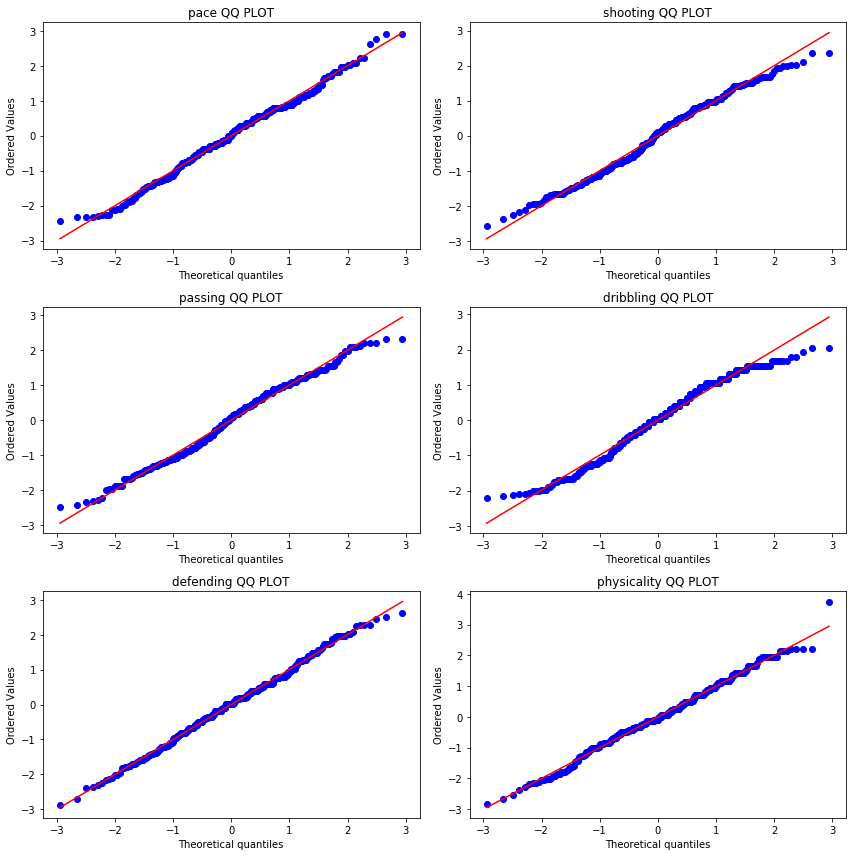

In [135]:
qqplot(defender_data_X_norm)

<h1> Linear Regression </h1>

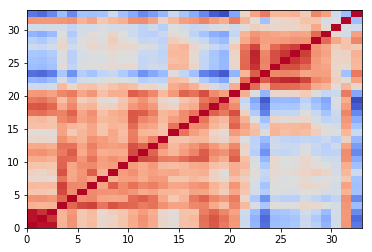

In [34]:
plt.pcolor(defender_data_X_norm.corr(),cmap='coolwarm')
plt.show()

In [35]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(x_train_norm,y_train)
defender_regression_score=model.score(x_test_norm, y_test)
defender_regression_score

-0.56019966978388

<h1> Random Forest </h1>

In [36]:
defender_parameters = grid_search(defender_data_X_norm, defender_data_y)
defender_parameters

{'max_depth': 8,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 30}

In [37]:
defender_importances, defender_forest_score = create_best_random_forest(defender_parameters, x_train_norm, y_train, x_test_norm, y_test, number_models = 100)
defender_importances_groups = list(zip(*defender_importances))
print(defender_forest_score)

-0.01988290816049991


Text(0.5,0,'Relative Importance')

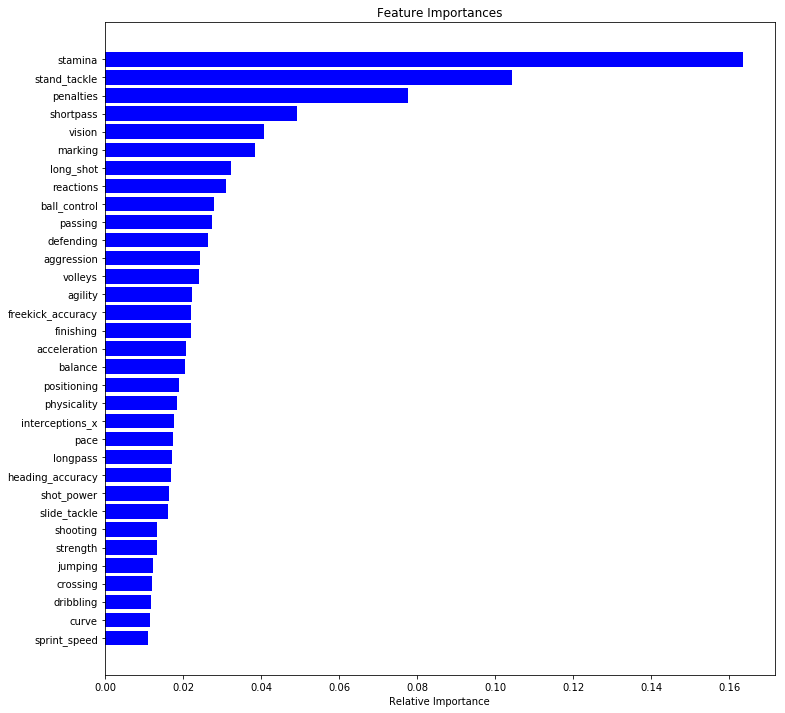

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(defender_importances_groups[0])), defender_importances_groups[0][::-1], color='b', align='center')
defender_feature_names = defender_importances_groups[1][::-1]

plt.yticks(range(len(defender_importances_groups[0])),defender_feature_names)
plt.xlabel('Relative Importance')

In [39]:
defender_forest_predictions = predicting(defender_parameters, defender_data_X_norm, defender_data_y, defender_2019, number_models=100)
defender_forest_predictions

[('Azpilicueta', 'Chelsea', 86, 68.63307225481849),
 ('Kyle Walker', 'Manchester City', 84, 63.544313975088485),
 ('Kieran Trippier', 'Tottenham Hotspur', 82, 61.79587662654797),
 ('Marcos Alonso', 'Chelsea', 82, 55.17620492711419),
 ('Andrew Robertson', 'Liverpool', 82, 53.709458447197356),
 ('Charlie Daniels', 'Bournemouth', 75, 53.704152389842015),
 ('Ben Davies', 'Tottenham Hotspur', 81, 51.721140664240295),
 ('Davide Zappacosta', 'Chelsea', 79, 50.91801402025962),
 ('Jan Vertonghen', 'Tottenham Hotspur', 87, 48.38824128056419),
 ('Diego Rico', 'Bournemouth', 76, 47.92591628790055),
 ('Daryl Janmaat', 'Watford', 77, 47.54916140985926),
 ('Adam Smith', 'Bournemouth', 76, 46.90609364087315),
 ('Adam Smith', 'Bournemouth', 76, 46.90609364087315),
 ('Sead Kolasinac', 'Arsenal', 80, 46.62886356966733),
 ('DeAndre Yedlin', 'Newcastle United', 76, 46.12732624338501),
 ('Leighton Baines', 'Everton', 78, 42.8613287955512),
 ('Ricardo Pereira', 'Leicester City', 81, 42.70886040508948),
 ('Da

<h2>Neural Network</h2>

In [136]:
defender_neural_parameters = grid_search_neural(defender_data_X_norm, defender_data_y)
defender_neural_parameters

{'activation': 'logistic',
 'hidden_layer_sizes': (60,),
 'learning_rate': 'adaptive',
 'max_iter': 1000,
 'solver': 'adam'}

In [137]:
defender_neural_score=average_network(defender_neural_parameters, x_train_norm, y_train, x_test_norm, y_test, number_models = 100)
defender_neural_score

-0.02022606710164918

In [138]:
defender_neural_prediction=predicting_network(defender_neural_parameters, defender_data_X_norm, defender_data_y, defender_2019, number_models=100)
defender_neural_prediction

[('Marcos Alonso', 'Chelsea', 82, 50.73379000651418),
 ('Kyle Walker', 'Manchester City', 84, 50.591447085890344),
 ('Azpilicueta', 'Chelsea', 86, 50.46524706359267),
 ('Kieran Trippier', 'Tottenham Hotspur', 82, 49.82462529931096),
 ('Ben Davies', 'Tottenham Hotspur', 81, 48.906962840044905),
 ('John Stones', 'Manchester City', 82, 48.405839973160354),
 ('Andrew Robertson', 'Liverpool', 82, 47.638570740371286),
 ('Benjamin Mendy', 'Manchester City', 81, 47.46236056361542),
 ('Toby Alderweireld', 'Tottenham Hotspur', 85, 47.258355440787426),
 ('Seamus Coleman', 'Everton', 80, 46.29351291613758),
 ('Jan Vertonghen', 'Tottenham Hotspur', 87, 45.80077816554634),
 ('Serge Aurier', 'Tottenham Hotspur', 80, 45.68721305114736),
 ('Victor Lindelof', 'Manchester United', 79, 45.60454341790676),
 ('Ricardo Pereira', 'Leicester City', 81, 45.5836736464771),
 ('Lucas Digne', 'Everton', 79, 45.5389896330366),
 ('Davinson Sanchez', 'Tottenham Hotspur', 84, 45.37677120607215),
 ('Antonio Valencia', '

<h1>MIDFIELDER CASE</h1>

In [139]:
midfielder_2019 = pd.read_csv('midfielder_2019.csv')
midfielder_2018 = pd.read_csv('midfielder_2018.csv')
midfielder_2017 = pd.read_csv('midfielder_2017.csv')
midfielder_2016 = pd.read_csv('midfielder_2016.csv')

In [140]:
midfielder_data = midfielder_2018.append(midfielder_2017,sort=False)
midfielder_data = midfielder_data.append(midfielder_2016, sort=False)
midfielder_predict = midfielder_2019

In [141]:
midfielder_data_X = midfielder_data.iloc[:,5:39]
midfielder_data_y = midfielder_data['goals'] + midfielder_data['assists']

midfielder_predict_X = midfielder_predict.iloc[:,5:39]
midfielder_predict_y = midfielder_predict['goals'] + midfielder_predict['assists']

In [142]:
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(midfielder_data, test_size = 0.3)
train = midfielder_2017.append(midfielder_2016)

x_train = train.iloc[:, 5:39]
y_train = train['goals'] + train['assists']

test = midfielder_2018
x_test = test.iloc[:, 5:39]
y_test = test['goals'] + test['assists']

In [143]:
midfielder_data_X_norm = data_preprocessing(midfielder_data_X)
midfielder_predict_X_norm = data_preprocessing(midfielder_predict_X)
x_train_norm = data_preprocessing(x_train)
x_test_norm = data_preprocessing(x_test)

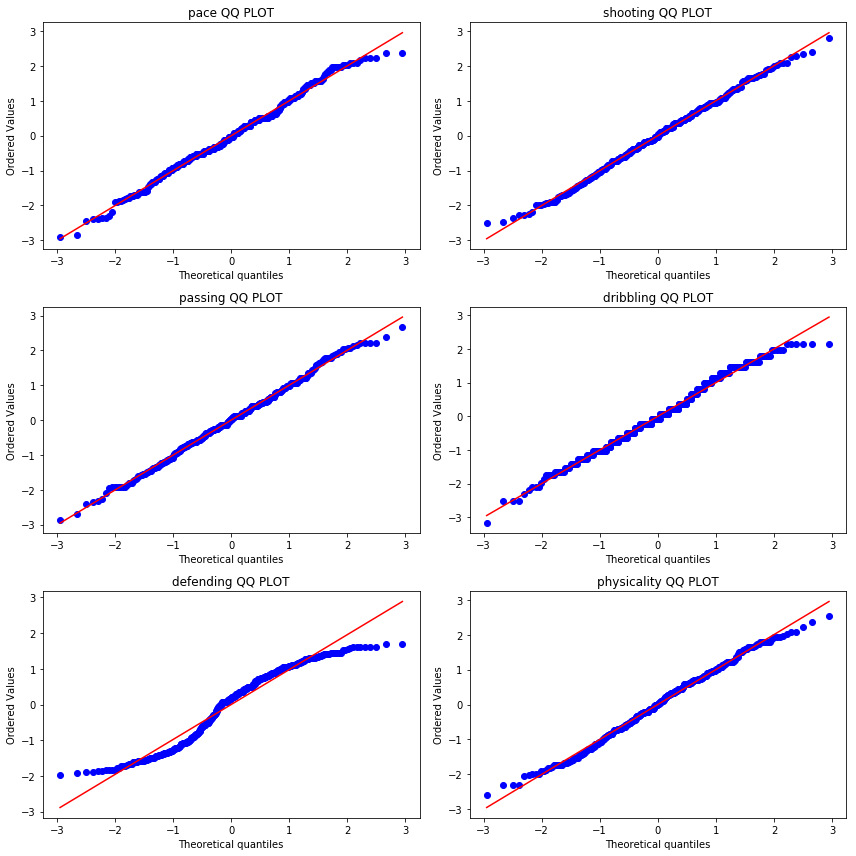

In [144]:
qqplot(midfielder_data_X_norm)

<h1> Linear Regression </h1>

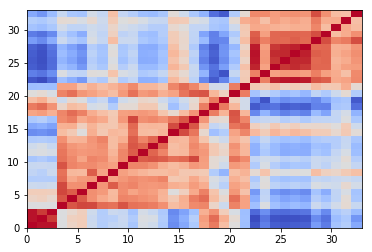

In [49]:
plt.pcolor(midfielder_data_X_norm.corr(),cmap='coolwarm')
plt.show()

In [50]:
model = linear_model.LinearRegression()
model.fit(x_train_norm,y_train)
midfielder_regression_score=model.score(x_test_norm, y_test)
midfielder_regression_score

-0.642987766104486

<h1> Random Forest </h1>

In [51]:
midfielder_parameters = grid_search(midfielder_data_X_norm, midfielder_data_y)
midfielder_parameters

{'max_depth': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 30}

In [52]:
midfielder_importances, midfielder_forest_score = create_best_random_forest(midfielder_parameters, x_train_norm, y_train, x_test_norm, y_test, number_models = 100)
midfielder_importances_groups = list(zip(*midfielder_importances))
print(midfielder_forest_score)

0.4275043949416221


Text(0.5,0,'Relative Importance')

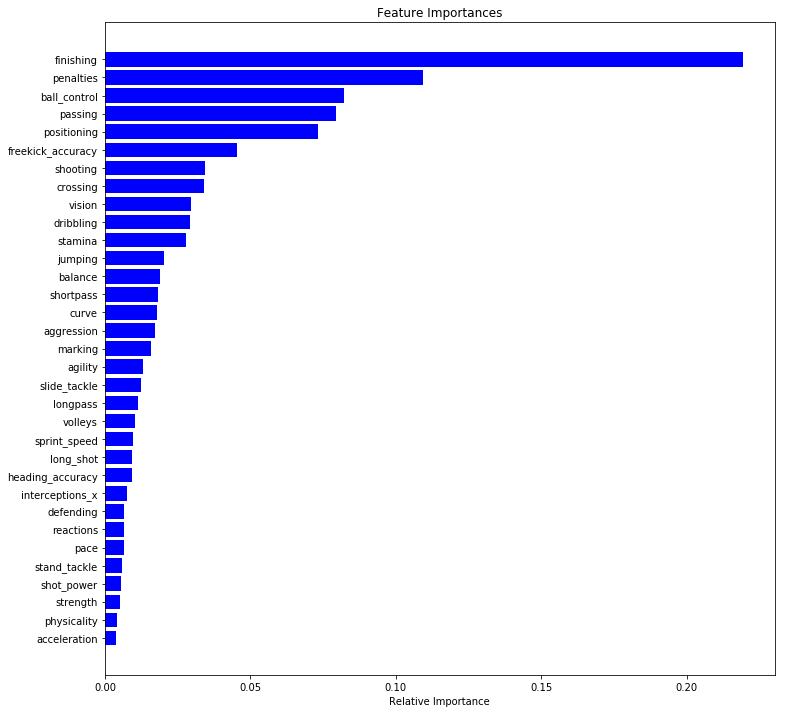

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(midfielder_importances_groups[0])), midfielder_importances_groups[0][::-1], color='b', align='center')
midfielder_feature_names = midfielder_importances_groups[1][::-1]

plt.yticks(range(len(midfielder_importances_groups[0])),midfielder_feature_names)
plt.xlabel('Relative Importance')

In [54]:
midfielder_forest_predictions = predicting(midfielder_parameters, midfielder_data_X_norm, midfielder_data_y, midfielder_2019, number_models=100)
midfielder_forest_predictions

[('Christian Eriksen', 'Tottenham Hotspur', 88, 19.634655536974538),
 ('Kevin De Bruyne', 'Manchester City', 91, 18.76921146330647),
 ('Riyad Mahrez', 'Manchester City', 85, 13.521523458637867),
 ('Dele Alli', 'Tottenham Hotspur', 84, 13.360060022932359),
 ('Mesut Ozil', 'Arsenal', 86, 13.066085038876544),
 ('David Silva', 'Manchester City', 89, 12.565818508928803),
 ('David Silva', 'Manchester City', 89, 12.565818508928803),
 ('David Silva', 'Manchester City', 89, 12.565818508928803),
 ('Jesse Lingard', 'Manchester United', 82, 12.534981219495435),
 ('Paul Pogba', 'Manchester United', 88, 10.571519145068295),
 ('Juan Mata', 'Manchester United', 83, 9.885851819293162),
 ('Marouane Fellaini', 'Manchester United', 79, 9.794381223841661),
 ('Aaron Ramsey', 'Arsenal', 82, 8.78637921161019),
 ('Cesc Fabregas', 'Chelsea', 83, 8.589189101089758),
 ('Henrikh Mkhitaryan', 'Arsenal', 83, 8.563992894740156),
 ('Felipe Anderson', 'West Ham United', 82, 8.290697173267672),
 ('Abdoulaye Doucoure', '

<h2>Neural Network</h2>

In [145]:
midfielder_neural_parameters = grid_search_neural(midfielder_data_X_norm, midfielder_data_y)
midfielder_neural_parameters

{'activation': 'logistic',
 'hidden_layer_sizes': (50,),
 'learning_rate': 'adaptive',
 'max_iter': 1000,
 'solver': 'sgd'}

In [146]:
midfielder_neural_score=average_network(midfielder_neural_parameters, x_train_norm, y_train, x_test_norm, y_test, number_models = 100)
midfielder_neural_score

0.3092100298932607

In [147]:
midfielder_neural_predictions=predicting_network(midfielder_neural_parameters, midfielder_data_X_norm, midfielder_data_y, midfielder_2019, number_models=10)
midfielder_neural_predictions

[('Christian Eriksen', 'Tottenham Hotspur', 88, 14.251087337773154),
 ('Kevin De Bruyne', 'Manchester City', 91, 13.60705215914515),
 ('Mesut Ozil', 'Arsenal', 86, 12.316289322815848),
 ('Dele Alli', 'Tottenham Hotspur', 84, 11.39940856492203),
 ('David Silva', 'Manchester City', 89, 11.04648736257647),
 ('David Silva', 'Manchester City', 89, 11.04648736257647),
 ('David Silva', 'Manchester City', 89, 11.04648736257647),
 ('Jesse Lingard', 'Manchester United', 82, 10.315107219625201),
 ('Andros Townsend', 'Crystal Palace', 78, 10.007865381670763),
 ('Riyad Mahrez', 'Manchester City', 85, 9.985379046083466),
 ('Juan Mata', 'Manchester United', 83, 9.29061434218872),
 ('Erik Lamela', 'Tottenham Hotspur', 81, 9.184900638267386),
 ('Paul Pogba', 'Manchester United', 88, 8.531078114897188),
 ('Aaron Ramsey', 'Arsenal', 82, 8.335069919795957),
 ('Henrikh Mkhitaryan', 'Arsenal', 83, 7.9718754531170335),
 ('Junior Stanislas', 'Bournemouth', 75, 7.935681790178297),
 ('Alex Iwobi', 'Arsenal', 77

<h1>FORWARD CASE</h1>

In [58]:
forward_2019 = pd.read_csv('forward_2019.csv')
forward_2018 = pd.read_csv('forward_2018.csv')
forward_2017 = pd.read_csv('forward_2017.csv')
forward_2016 = pd.read_csv('forward_2016.csv')

In [59]:
forward_data = forward_2018.append(forward_2017)
forward_data = forward_data.append(forward_2016)
forward_predict = forward_2019

In [60]:
forward_data_X = forward_data.iloc[:,5:39]
forward_data_y = forward_data['goals']

forward_predict_X = forward_predict.iloc[:,5:39]
forward_predict_y = forward_predict['goals']

In [61]:
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(midfielder_data, test_size = 0.3)
train = forward_2017.append(forward_2016)

x_train = train.iloc[:, 5:39]
y_train = train['goals']

test = forward_2016

x_test = test.iloc[:, 5:39]
y_test = test['goals']

In [62]:
forward_data_X_norm = data_preprocessing(forward_data_X)
forward_predict_X_norm = data_preprocessing(forward_predict_X)
x_train_norm = data_preprocessing(x_train)
x_test_norm = data_preprocessing(x_test)

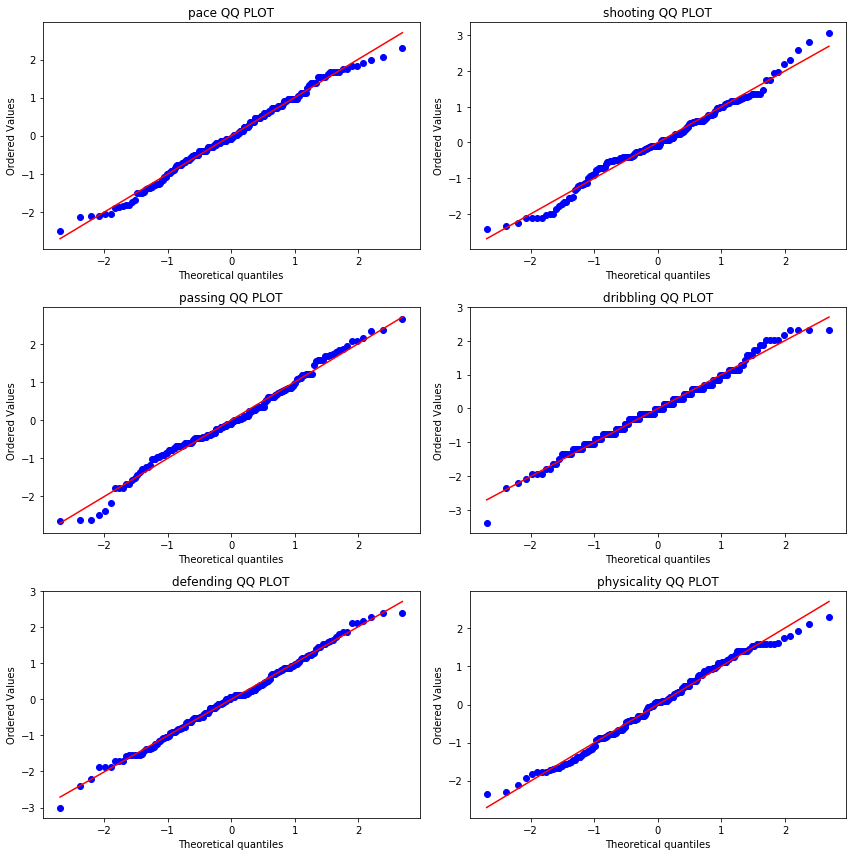

In [63]:
qqplot(forward_data_X_norm)

<h1> Linear Regression </h1>

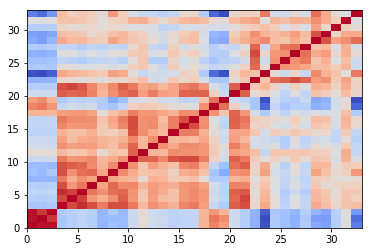

In [64]:
plt.pcolor(forward_data_X_norm.corr(),cmap='coolwarm')
plt.show()

In [65]:
model = linear_model.LinearRegression()
model.fit(x_train_norm,y_train)
forward_regression_score=model.score(x_test_norm, y_test)
forward_regression_score

0.25289821115675215

<h1> Random Forest </h1>

In [66]:
forward_parameters = grid_search(forward_data_X_norm, forward_data_y)
forward_parameters

{'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 20}

In [67]:
forward_importances, forward_forest_score = create_best_random_forest(forward_parameters, x_train_norm, y_train, x_test_norm, y_test, number_models = 100)
forward_importances_groups = list(zip(*forward_importances))
print(forward_forest_score)

0.7896488452488449


Text(0.5,0,'Relative Importance')

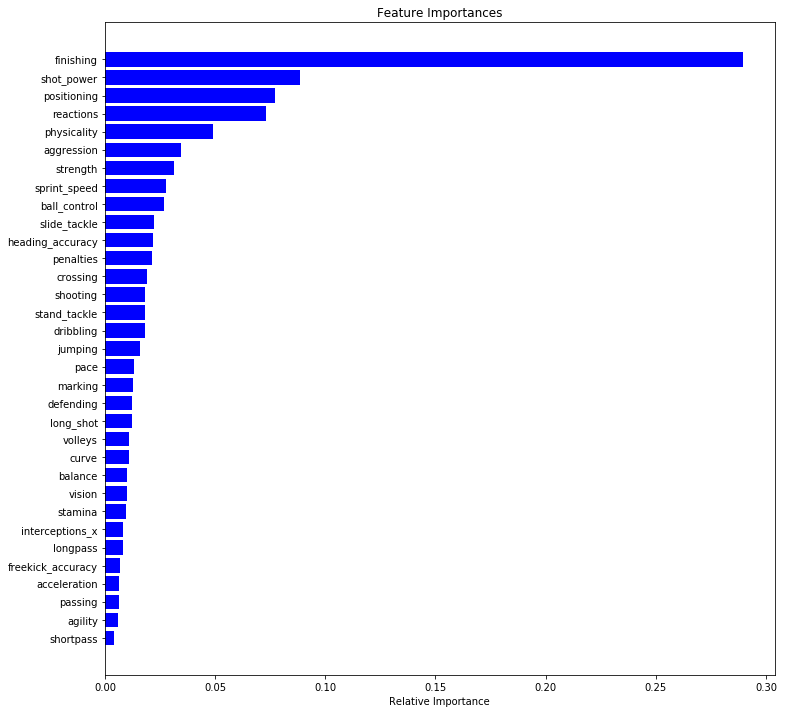

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(forward_importances_groups[0])), forward_importances_groups[0][::-1], color='b', align='center')
forward_feature_names = forward_importances_groups[1][::-1]

plt.yticks(range(len(forward_importances_groups[0])),forward_feature_names)
plt.xlabel('Relative Importance')

In [69]:
forward_forest_predictions = predicting(forward_parameters, x_train_norm, y_train, forward_2019, number_models=100)
forward_forest_predictions

[('Harry Kane', 'Tottenham Hotspur', 89, 19.940417743712892),
 ('Sergio Aguero', 'Manchester City', 89, 19.524696811007903),
 ('Romelu Lukaku', 'Manchester United', 87, 17.8288629058882),
 ('Roberto Firmino', 'Liverpool', 86, 16.611029891907464),
 ('Alexandre Lacazette', 'Arsenal', 84, 13.852537895218635),
 ('Pierre-Emerick Aubameyang', 'Arsenal', 88, 12.63740471631334),
 ('Jamie Vardy', 'Leicester City', 82, 12.403433749939088),
 ('Gabriel Jesus', 'Manchester City', 83, 8.600373628289768),
 ('Troy Deeney', 'Watford', 77, 8.128109141723009),
 ('Laurent Depoitre', ' Huddersfield Town', 75, 7.752941183822688),
 ('Marko Arnautovic', 'West Ham United', 82, 7.161224054499206),
 ('Llorente', 'Tottenham Hotspur', 76, 7.137468160862289),
 ('Olivier Giroud', 'Chelsea', 82, 7.018333013385821),
 ('Wilfried Zaha', 'Crystal Palace', 82, 6.5059768783885135),
 ('Steve Mounie', 'Huddersfield Town', 76, 6.003703102659051),
 ('Glenn Murray', 'Brighton and Hove Albion', 76, 5.90823336501363),
 ('Salomon 

<h2>Neural Network</h2>

In [70]:
forward_neural_parameters = grid_search_neural(forward_data_X, forward_data_y)
forward_neural_parameters


{'activation': 'relu',
 'hidden_layer_sizes': (40,),
 'learning_rate': 'invscaling',
 'max_iter': 500,
 'solver': 'lbfgs'}

In [71]:
forward_neural_score=average_network(forward_neural_parameters, x_train_norm, y_train, x_test_norm, y_test, number_models = 100)
forward_neural_score

0.9159965204741494

In [72]:
forward_neural_prediction=predicting_network(forward_neural_parameters, forward_data_X_norm, forward_data_y, forward_2019, number_models=100)
forward_neural_prediction

[('Harry Kane', 'Tottenham Hotspur', 89, 35.12094623842329),
 ('Glenn Murray', 'Brighton and Hove Albion', 76, 19.315765008556067),
 ('Sergio Aguero', 'Manchester City', 89, 19.173651122597445),
 ('Romelu Lukaku', 'Manchester United', 87, 15.66464873517238),
 ('Jamie Vardy', 'Leicester City', 82, 15.4879334062445),
 ('Morata', 'Chelsea', 82, 11.369069239311104),
 ('Adama Diakhaby', 'Huddersfield Town', 74, 11.098159661117327),
 ('Salomon Rondon', 'Newcastle United', 77, 10.960369060834427),
 ('Ashley Barnes', 'Burnley', 77, 10.818040577057184),
 ('Alexandre Lacazette', 'Arsenal', 84, 10.683264817870755),
 ('Llorente', 'Tottenham Hotspur', 76, 10.505332366203806),
 ('Roberto Firmino', 'Liverpool', 86, 10.402399623859775),
 ('Chris Wood', 'Burnley', 77, 10.280377947637424),
 ('Oumar Niasse', 'Everton', 75, 9.5885520261134),
 ('Gabriel Jesus', 'Manchester City', 83, 9.492591681548133),
 ('Laurent Depoitre', ' Huddersfield Town', 75, 9.40461443024),
 ('Kazaiah Sterling', 'Tottenham Hotspur

In [148]:
goalkeeper_score = ['goalkeepers',goalkeeper_regression_score, goalkeeper_forest_score, goalkeeper_neural_score, 'saves']
defender_score = ['defenders', defender_regression_score, defender_forest_score, defender_neural_score, 'tackles']
midfielder_score = ['midfielders', midfielder_regression_score, midfielder_forest_score, midfielder_neural_score, 'contribution']
forward_score = ['forward', forward_regression_score, forward_forest_score, forward_neural_score, 'goals']

In [149]:
score_df = pd.DataFrame([goalkeeper_score, defender_score, midfielder_score, forward_score], columns=['position','regression', 'random_forest', 'neural_network', 'dependent_var'])
score_df = score_df.set_index('position')
score_df

,regression,random_forest,neural_network,dependent_var
position,,,,
goalkeepers,-3.737881,0.117374,0.182987,saves
defenders,-0.560200,-0.019883,-0.020226,tackles
midfielders,-0.642988,0.427504,0.309210,contribution
forward,0.252898,0.789649,0.915997,goals


In [150]:
goalkeeper_predictions = goalkeeper_neural_predictions[:5]
defender_predictions = defender_forest_predictions[:5]
midfielder_predictions = midfielder_forest_predictions[:5]
forward_predictions = forward_forest_predictions[:5]


<h1> SUMMARY </h1>
<li>Our predicted top scorer (in EPL, the player wins the "Golden Boot" trophy) in the league was Harry Kane with 35 goals
<li>Used random forest to determine what features were the most useful for each cathegory </li>
 <ul>   
    <li> Goalkeepers: Short Passes (we would expect it to be Reactions, the second feature)
    <li> Defenders: Stamina (we would expect it to be Tackling)
    <li> Midfielders: Finishing (we would expect it to be Passing)
    <li> Forwards: Finishing (at least this one is as expected!)
</ul>

<li>Using Regression, Random Forest and Neural Networks, we established a predited "top 5" best players of the season for each position (gk: saves, def: tackles, mid: passes+goals, fwd: goals)</li>
<li>To relate back to FIFA 19 gamers, we found the strongest team possible that could be made in the game


In [151]:
df_gk= pd.DataFrame(goalkeeper_predictions, columns=['name', 'team', 'overall_rating', 'predicted_dependent_var'])
df_gk = df_gk.set_index('name')
df_gk

,team,overall_rating,predicted_dependent_var
name,,,
Lukasz Fabianski,West Ham United,81,77.589636
Ederson,Manchester City,86,70.219955
De Gea,Manchester United,91,70.098273
Petr Cech,Arsenal,82,68.224047
Alisson,Liverpool,85,67.355356


In [152]:
df_def= pd.DataFrame(defender_predictions, columns=['name', 'team', 'overall_rating', 'predicted_dependent_var'])
df_def = df_def.set_index('name')
df_def

,team,overall_rating,predicted_dependent_var
name,,,
Azpilicueta,Chelsea,86,68.633072
Kyle Walker,Manchester City,84,63.544314
Kieran Trippier,Tottenham Hotspur,82,61.795877
Marcos Alonso,Chelsea,82,55.176205
Andrew Robertson,Liverpool,82,53.709458


In [153]:
df_mid= pd.DataFrame(midfielder_predictions, columns=['name', 'team', 'overall_rating', 'predicted_dependent_var'])
df_mid = df_mid.set_index('name')
df_mid

,team,overall_rating,predicted_dependent_var
name,,,
Christian Eriksen,Tottenham Hotspur,88,19.634656
Kevin De Bruyne,Manchester City,91,18.769211
Riyad Mahrez,Manchester City,85,13.521523
Dele Alli,Tottenham Hotspur,84,13.360060
Mesut Ozil,Arsenal,86,13.066085


In [154]:
df_fw= pd.DataFrame(forward_predictions, columns=['name', 'team', 'overall_rating', 'predicted_dependent_var'])
df_fw = df_fw.set_index('name')
df_fw

,team,overall_rating,predicted_dependent_var
name,,,
Harry Kane,Tottenham Hotspur,89,19.940418
Sergio Aguero,Manchester City,89,19.524697
Romelu Lukaku,Manchester United,87,17.828863
Roberto Firmino,Liverpool,86,16.611030
Alexandre Lacazette,Arsenal,84,13.852538


<h2> Best LineUp For This Season </h2>

In [155]:
goalkeeper = goalkeeper_predictions[0]
defenders = defender_predictions[0:4]
midfielders = midfielder_predictions[0:4]
forwards= forward_predictions[:2]

In [156]:
line_up = pd.DataFrame([goalkeeper,*defenders,*midfielders,*forwards], columns=['name', 'team', 'overall_rating', 'predicted_dependent_var'] )
line_up = line_up.iloc[:,0:3]
line_up

,name,team,overall_rating
0,Lukasz Fabianski,West Ham United,81
1,Azpilicueta,Chelsea,86
2,Kyle Walker,Manchester City,84
3,Kieran Trippier,Tottenham Hotspur,82
4,Marcos Alonso,Chelsea,82
5,Christian Eriksen,Tottenham Hotspur,88
6,Kevin De Bruyne,Manchester City,91
7,Riyad Mahrez,Manchester City,85
8,Dele Alli,Tottenham Hotspur,84
9,Harry Kane,Tottenham Hotspur,89


<h1>Why is this project useful?</h1>
<li>In 2018, Premier League teams have invested between 500 Million and 100 Million british pounds on buying players. This model should assist them in finding the right value of a player, for instance</li>
<li>Nowadays anybody can bet on games, not only the final score but also what players is going to perform well, etc. We are NOT encouraging you to bet money on soccer games but if you are going to anyway this project can definetly provide some very interesting insights for you!</li>
<li>This study does produce some interesting results besides from predicting outcomes, as it shows that characteristics that seem somewhat unrelated do actually mater for a player's performance
<li>Finally,for gamers who play FIFA, the maker of the game EA Sports doesn't release information about how they gather the players' statistics, so this model should also be of help to them so they can understand why a player is well-rated or not, ending many never-ending debates 